# Hypothesis Functionality

## Goals
We want a hypothesis that is:
- Simple. As few nodes as possible.
- Probable. Should have a high probability of being true

## Important Functions
- Write the Graph
- Learn the CPT Table
- ObserveData: Should be done after CPT Table is created but before hypothesis testing
- GetMarkovBlanket gets the markov blanket of our observed data
- GetTotalProbability

In [1]:
# add observations to a graph
def observeData(graph, true_nodes, false_nodes):
    nodes = graph.nodes()
    for i in nodes:
        if i in true_nodes:
            graph.nodes[i]['value'] = True
        if i in false_nodes:
            graph.nodes[i]['value'] = False
        else:
            graph.nodes[i]['value'] = 0

In [2]:
class CPT(object):
    """
    Defines a CPT Class
    """
    def __init__(self, num_parents):
        self.num_parents = num_parents
        self.CPTable = self.make_table()
        
    def make_table(self):
        CPTable = {}
        if self.num_parents > 0:
            for i in range(2**self.num_parents):
                CPTable[bin(i)] = 0.0
        else:
            CPTable['self'] = 0.0
        return CPTable
    
    def add_entry(self, parent_values, prob):
        # values of nodes sorted in alphabetical order
        key = ''
        for i in parent_values:
            key += str(i)
        self.CPTable[bin(int(key, 2))] = prob 
    
    def add_entry_self(self, prob):
        self.CPTable['self'] = prob
    
    def get_entry(self, parent_values):
        key = ''
        for i in parent_values:
            key += str(i)
        return self.CPTable[bin(int(key, 2))]
    
    def get_entry_bin(self, parent_bin):
        return self.CPTable[parent_bin]
    
    def get_entry_self(self):
        return self.CPTable['self']
    
    def get_table(self):
        return self.CPTable

In [3]:
def getMarkovBlanket(graph, obs, hyp):
    #generates a new graph (markov blanket) based on the graph, observations, and hypothesis
    #get all parent nodes
    edge_attrs = nx.get_edge_attributes(graph, 'weight')
    new_graph = nx.DiGraph()
    new_graph.add_node(hyp)
    new_graph.add_nodes_from(obs)
    for i in edge_attrs:
        if i[0] in obs or i[0] == hyp:
            new_graph.add_node(i[1])
            new_graph.add_edge(i[0], i[1], weight=edge_attrs[i])
        if i[1] in obs or i[1] == hyp:
            new_graph.add_node(i[0])
            new_graph.add_edge(i[0], i[1], weight=edge_attrs[i])
    return new_graph

In [8]:
def calculateTotalProbability(blanket, hyp, obs):
    #calculate node probability given children
    # want to calculate hyp | obs
    # the way i do this is kind of crazy. 
    sorted_nodes = sorted(blanket.nodes())
    num_prob = 0
    ## [blanket.predecessors(item) for item in sorted_nodes if (item != hyp or not item in obs)]
    preds = [blanket.predecessors(item) for item in sorted_nodes]
    no_preds = [item for item in sorted_nodes if len(list(blanket.predecessors(item))) == 0]
    num = 2**sum([len(list(item)) for item in preds])
    for i in range(num):
        bin_num = bin(num)
        str_bin_num = str(bin_num)[2:]
        total_len_so_far = 0
        total = 1
        for x in sorted_nodes:
            if not x in no_preds:
                key = str_bin_num[total_len_so_far:total_len_so_far + len(x)]
                total *= blanket.node[x]['CPT'].get_entry_bin(bin(int(key, 2)))
        for z in no_preds:
            total *= blanket.node[z]['CPT'].get_entry_self()
        num_prob += total
        
    denom_prob = 0 
    preds = [blanket.predecessors(item) for item in sorted_nodes if (item != hyp)]
    num = 2**sum([len(list(item)) for item in preds])
    for i in range(num):
        bin_num = bin(num)
        str_bin_num = str(bin_num)[2:]
        total_len_so_far = 0
        total = 1
        for x in sorted_nodes:
            if x != hyp and not x in no_preds:
                key = str_bin_num[total_len_so_far:total_len_so_far + len(x)]
                print(blanket.node[x]['CPT'].get_entry_bin(bin(int(key, 2))))
                print(blanket.node[x]['CPT'].get_table())
                print(key)
                total *= blanket.node[x]['CPT'].get_entry_bin(bin(int(key, 2)))
            for z in no_preds:
                total *= blanket.node[z]['CPT'].get_entry_self()
            denom_prob += total
    return num_prob/denom_prob

## Testing Things
### Making the graph! 
- Based off the example found [HERE](https://www.ics.uci.edu/~rickl/courses/cs-171/2012-wq-cs171/2012-wq-cs171-lecture-slides/2012wq171-17-BayesianNetworks.pdf)

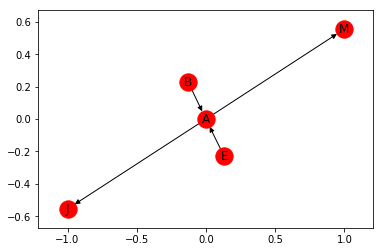

In [9]:
from similarityfunctions import *
import networkx as nx
from itertools import permutations
dg = nx.DiGraph()
dg.add_nodes_from(['B', 'E', 'A', 'M', 'J'])
dg.add_edges_from([('B','A'),('E','A'),('A', 'M'),('A','J')])
nx.draw_networkx(dg)

### Learning the CPTable

In [10]:
# burglar
cpt_B = CPT(0)
cpt_B.add_entry_self(.001)
dg.node['B']['CPT'] = cpt_B
# earthquake
cpt_E = CPT(0)
cpt_E.add_entry_self(.002)
dg.node['E']['CPT'] = cpt_E
#alarm
cpt_A = CPT(2)
cpt_A.add_entry([1, 1], .95)
cpt_A.add_entry([1, 0], .94)
cpt_A.add_entry([0, 1], .29)
cpt_A.add_entry([0, 0], .001)
dg.node['A']['CPT'] = cpt_A
#john calls
cpt_J = CPT(1)
cpt_J.add_entry([1], .9)
cpt_J.add_entry([0], .05)
dg.node['J']['CPT'] = cpt_J
#mary calls
cpt_M = CPT(1)
cpt_M.add_entry([1], .7)
cpt_M.add_entry([0], .01)
dg.node['M']['CPT'] = cpt_M

### Finding probabilities (fingers crossed!)

In [11]:
calculateTotalProbability(dg, 'B', ['M', 'J'])

0.29
{'0b0': 0.001, '0b1': 0.29, '0b10': 0.94, '0b11': 0.95}
1
0.9
{'0b0': 0.05, '0b1': 0.9}
1
0.7
{'0b0': 0.01, '0b1': 0.7}
1
0.29
{'0b0': 0.001, '0b1': 0.29, '0b10': 0.94, '0b11': 0.95}
1
0.9
{'0b0': 0.05, '0b1': 0.9}
1
0.7
{'0b0': 0.01, '0b1': 0.7}
1
0.29
{'0b0': 0.001, '0b1': 0.29, '0b10': 0.94, '0b11': 0.95}
1
0.9
{'0b0': 0.05, '0b1': 0.9}
1
0.7
{'0b0': 0.01, '0b1': 0.7}
1
0.29
{'0b0': 0.001, '0b1': 0.29, '0b10': 0.94, '0b11': 0.95}
1
0.9
{'0b0': 0.05, '0b1': 0.9}
1
0.7
{'0b0': 0.01, '0b1': 0.7}
1
0.29
{'0b0': 0.001, '0b1': 0.29, '0b10': 0.94, '0b11': 0.95}
1
0.9
{'0b0': 0.05, '0b1': 0.9}
1
0.7
{'0b0': 0.01, '0b1': 0.7}
1
0.29
{'0b0': 0.001, '0b1': 0.29, '0b10': 0.94, '0b11': 0.95}
1
0.9
{'0b0': 0.05, '0b1': 0.9}
1
0.7
{'0b0': 0.01, '0b1': 0.7}
1
0.29
{'0b0': 0.001, '0b1': 0.29, '0b10': 0.94, '0b11': 0.95}
1
0.9
{'0b0': 0.05, '0b1': 0.9}
1
0.7
{'0b0': 0.01, '0b1': 0.7}
1
0.29
{'0b0': 0.001, '0b1': 0.29, '0b10': 0.94, '0b11': 0.95}
1
0.9
{'0b0': 0.05, '0b1': 0.9}
1
0.7
{'0b0': 0.01

0.62999874

## Stuff to Implement Soon

In [97]:
# Finds a bunch of hypothesis. Does nothing yet
def findBestExplanation(graph, true_nodes, false_nodes):
    hyps = findHypothesis(graph, true_nodes, false_nodes)

In [98]:
# Finds all possible hypothesis
def findHypotheses(graph, true_nodes, false_nodes):
    hyps = []
    for i in graph.nodes():
        children = get_all_children(graph, i, {}, 1)
        if all(item in children.keys() for item in true_nodes) and not any(item in children.keys() for item in false_nodes):
            hyps.append(i)
    return hyps

In [99]:
# Something to calculate new markov blanket probabilities- talk with Hana!!

## Stuff we're probably not using

In [90]:
# adds new true nodes and new false nodes to the graph and then checks for contradictions
# only finds direct contraidctions? Should talk with group about this.
import copy 
def findContradictions(graph, new_true_nodes, new_false_nodes, threshold=.5):
    new_g = copy.deepcopy(graph)
    observeData(new_g, new_true_nodes, new_false_nodes)
    edge_attrs = nx.get_edge_attributes(new_g, 'weight')
    for i in new_g.nodes():
        if 'observed' in new_g.nodes.data()[i]:
            if new_g.nodes.data()[i]['observed'] is True:
                for x in edge_attrs:
                    print(x, x[1], new_g.nodes.data()[x[1]], edge_attrs[x])
                    if 'observed' in new_g.nodes.data()[x[1]]:
                        if x[0] == i and new_g.nodes.data()[x[1]]['observed'] is False and edge_attrs[x] >= threshold:
                            return (i, True, x[1], False, edge_attrs[x])
    return "No contradictions found"

In [96]:
# sees if some nodes are independent based on the nodes we are conditioning on
# we are only checking for *direct* conditions. chains are not accounted for
# since in baysien networks edges are "direct dependence." Should double-check this.
def independenceChecker(graph, conditions, nodes):
    edges = nx.get_edge_attributes(graph, 'weight')
    for i in edges:
        if i[1] in nodes and not i[0] in conditions:
            return False
    return True